# Разработка алгоритма классификации требований нормативных документов с использованием машинного обучения.

In [1]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn import metrics

In [2]:
def normalization_v2(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace("‘", '‘').replace("’", '’').replace("'", " '")
    text = re.sub(r"['‘’]\w+\b", '', text)
    text = re.sub(r"['‘’]", '', text)
    text = re.sub(r'[“”"•]', '', text)
    
    x = re.findall(r"\d", "ldcnk skjnk njdjm")    #numbers in text
    
    text = re.sub(r'(\d\.\s)+', '', text)
    text = re.sub(r'(\d\.)+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"–", '', text)
#    text = re.sub(r"\s\w\s", '', text)
    if len(x) > 0:                              #marker that there were numbers in text
        text += '11111'
    text = text.strip()
    lemma = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    text = ""
    for tok in tokens:
        text += tok
        text += " "
    return text

In [3]:
df_1 = pd.read_csv('Train_Standards-Table_clear.csv', sep=';', header = None)
df_1.columns=['Source document ID', 'CI_ID', 'CI_Version', 'CI_Description EN', 'DocumentObjectClass']
df_1.head(7)

,Source document ID,CI_ID,CI_Version,CI_Description EN,DocumentObjectClass
0,IAEA-GSR2,IAEA-GSR2-1,6-2016,Requirement 1: Achieving the fundamental safet...,Requirement
1,IAEA-GSR2,IAEA-GSR2-1-2.2,6-2016,"2.2. The senior management of organizations, i...",Requirement
2,IAEA-GSR2,IAEA-GSR2-2-3.1,6-2016,3.1. The senior management of the organization...,Requirement
3,IAEA-GSR2,IAEA-GSR2-2-3.3,6-2016,3.3. Managers at all levels in the organizatio...,Requirement
4,IAEA-GSR2,IAEA-GSR2-3-4.1,6-2016,4.1. Senior management shall retain accountabi...,Requirement
5,IAEA-GSR2,IAEA-GSR2-4,6-2016,"Requirement 4: Goals, strategies, plans and ob...",Requirement
6,IAEA-GSR2,IAEA-GSR2-4-4.4,6-2016,4.4. Senior management shall ensure that measu...,Requirement


In [4]:
df_2 = pd.read_csv('Test_Standards-Table_clear.csv', sep=';', header = None)
df_2.columns=['Source document ID', 'CI_ID', 'CI_Version', 'CI_Description EN', 'DocumentObjectClass']
df_2.head()

,Source document ID,CI_ID,CI_Version,CI_Description EN,DocumentObjectClass
0,IAEA-GSR2,IAEA-GSR2-1-2.1,6-2016,2.1. The registrant or licensee shall ensure t...,Requirement
1,IAEA-GSR2,IAEA-GSR2-2,6-2016,Requirement 2: Demonstration of leadership for...,Requirement
2,IAEA-GSR2,IAEA-GSR2-2-3.2,6-2016,3.2. Managers at all levels in the organizatio...,Requirement
3,IAEA-GSR2,IAEA-GSR2-3,6-2016,Requirement 3: Responsibility of senior manage...,Requirement
4,IAEA-GSR2,IAEA-GSR2-3-4.2,6-2016,4.2. Senior management shall be responsible fo...,Requirement


In [5]:
df_1['CI_Description EN'].head(10)

0    Requirement 1: Achieving the fundamental safet...
1    2.2. The senior management of organizations, i...
2    3.1. The senior management of the organization...
3    3.3. Managers at all levels in the organizatio...
4    4.1. Senior management shall retain accountabi...
5    Requirement 4: Goals, strategies, plans and ob...
6    4.4. Senior management shall ensure that measu...
7    Requirement 5: Interaction with interested par...
8    4.7. Senior management shall ensure that the p...
9    4.8. The management system shall be developed,...
Name: CI_Description EN, dtype: object

In [6]:
df1 = pd.DataFrame(columns=['text', 'class'])
df2 = pd.DataFrame(columns=['text', 'class'])
df1['text'] = df_1['CI_Description EN']
df1['class'] = df_1['DocumentObjectClass']
df2['text'] = df_2['CI_Description EN']
df2['class'] = df_2['DocumentObjectClass']
df1['data'] = df1['text'].str.lower()
df2['data'] = df2['text'].str.lower()
df1['data'] = df1['data'].apply(lambda x: normalization_v2(x))
df2['data'] = df2['data'].apply(lambda x: normalization_v2(x))

In [7]:
df1['data'].head()

0    requirement achieve the fundamental safety obj...
1    the senior management of organization in accor...
2    the senior management of the organization shal...
3    manager at all level in the organization a sha...
4    senior management shall retain accountability ...
Name: data, dtype: object

In [8]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df1['data'])
tfidf_transformer = TfidfTransformer()
train_tfidf_transformer = tfidf_transformer.fit(X_counts)

In [9]:
X_train = train_tfidf_transformer.transform(X_counts)
le = preprocessing.LabelEncoder()
le.fit(df1['class'])
y_train = le.transform(df1['class'])

In [10]:
X_test = train_tfidf_transformer.transform(count_vect.transform(df2['data']))
le = preprocessing.LabelEncoder()
le.fit(df2['class'])
y_test = le.transform(df2['class'])

In [11]:
df_1['CI_Description EN'].head()

0    Requirement 1: Achieving the fundamental safet...
1    2.2. The senior management of organizations, i...
2    3.1. The senior management of the organization...
3    3.3. Managers at all levels in the organizatio...
4    4.1. Senior management shall retain accountabi...
Name: CI_Description EN, dtype: object

In [12]:
X_train

<1880x2580 sparse matrix of type '<class 'numpy.float64'>'
	with 44503 stored elements in Compressed Sparse Row format>

In [13]:
df_1['DocumentObjectClass'].head()

0    Requirement
1    Requirement
2    Requirement
3    Requirement
4    Requirement
Name: DocumentObjectClass, dtype: object

In [14]:
y_train

array([3, 3, 3, ..., 3, 3, 3])

## Modal verb Shall

In [15]:
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(df2['data'])):
    if (df2['data'][i].find('shall') != -1 and df2['class'][i] == 'Requirement'): TP += 1
    elif (df2['data'][i].find('shall') != -1 and df2['class'][i] != 'Requirement'): FP += 1
    elif (df2['data'][i].find('shall') == -1 and df2['class'][i] == 'Requirement'): FN += 1
    elif (df2['data'][i].find('shall') == -1 and df2['class'][i] != 'Requirement'): TN += 1
        
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * TP / (2 * TP + FP + FN)

print ('precision =', precision)
print ('recall =', recall)
print ('f1 =', f1)

precision = 0.9820742637644047
recall = 0.5304287690179806
f1 = 0.688819039066008


In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(df2)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
     if (df2['class'][i] == 'Requirement'): y_test_roc[i] = 1
        
for i in range (length):
    shall = df2['data'][i].find('shall')
    if (shall != -1):
        y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

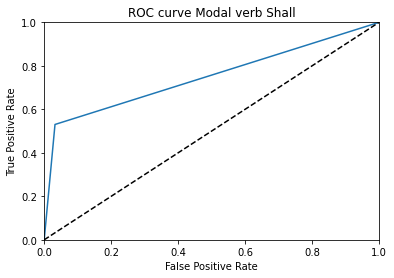

In [17]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Modal verb Shall')
plt.show()

fig.savefig('ROC curve Modal verb Shall')

In [18]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))

AUC ROC 0.7490853522509258


## Modal verbs: may, might, can, could, must, shall, should

In [19]:
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(0, len(df2)):
    may = df2['data'][i].find('may')
    might = df2['data'][i].find('might')
    can = df2['data'][i].find('can')
    could = df2['data'][i].find('could')
    must = df2['data'][i].find('must')
    shall = df2['data'][i].find('shall')
    should = df2['data'][i].find('should')
    
    if ((may != -1 or might != -1 or can != -1 or could != -1 or must != -1 or shall != -1 or should != -1)
        and df2['class'][i] == 'Requirement'): TP += 1
    elif ((may != -1 or might != -1 or can != -1 or could != -1 or must != -1 or shall != -1 or should != -1)
        and df2['class'][i] != 'Requirement'): FP += 1
    elif ((may == -1 and might == -1 and can == -1 and could == -1 and must == -1 and shall == -1 and should == -1)
        and df2['class'][i] == 'Requirement'): FN += 1
    elif ((may == -1 and might == -1 and can == -1 and could == -1 and must == -1 and shall == -1 and should == -1)
        and df2['class'][i] != 'Requirement'): TN += 1
        
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * TP / (2 * TP + FP + FN)

print ('precision =', precision)
print ('recall =', recall)
print ('f1 =', f1)

precision = 0.9308790383170549
recall = 0.8568464730290456
f1 = 0.8923298523586605


In [20]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(df2)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
     if (df2['class'][i] == 'Requirement'): y_test_roc[i] = 1
        
for i in range (length):
    may = df2['data'][i].find('may')
    might = df2['data'][i].find('might')
    can = df2['data'][i].find('can')
    could = df2['data'][i].find('could')
    must = df2['data'][i].find('must')
    shall = df2['data'][i].find('shall')
    should = df2['data'][i].find('should')
    if (may != -1 or might != -1 or can != -1 or could != -1 or must != -1 or shall != -1 or should != -1):
        y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

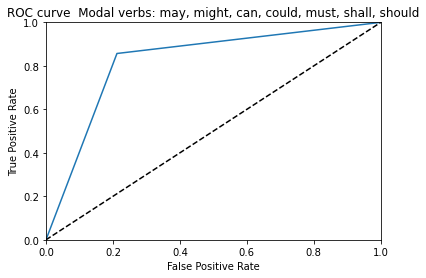

In [21]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve  Modal verbs: may, might, can, could, must, shall, should')
plt.show()

fig.savefig('ROC curve Modal verbs: may, might, can, could, must, shall, should')

In [22]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))
print ("MSE", metrics.mean_squared_error(y_test_roc, y_pred_roc))
print ("MAE", metrics.mean_absolute_error(y_test_roc, y_pred_roc))

AUC ROC 0.8224324531043847
MSE 0.15904255319148936
MAE 0.15904255319148936


## GaussianNB

In [23]:
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
y_pred = gnb.predict(X_test.toarray())

print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))

beta = 0.5
print ("beta =", beta, 'fbeta_score =', metrics.fbeta_score(y_test, y_pred, beta = beta, average='weighted'))

              precision    recall  f1-score   support

      Figure       0.20      0.20      0.20         5
     Heading       0.82      0.46      0.59       253
 Information       0.15      0.30      0.20       169
 Requirement       0.88      0.82      0.85      1446
       Title       0.02      0.14      0.04         7

    accuracy                           0.72      1880
   macro avg       0.41      0.38      0.37      1880
weighted avg       0.80      0.72      0.75      1880

beta = 0.5 fbeta_score = 0.7795890446349466


In [24]:
random_search = {'var_smoothing': list(np.linspace(1e-8, 1e-10, 100, dtype = float))}

clf = GaussianNB()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train.toarray(),y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   15.6s finished


RandomizedSearchCV(cv=4, estimator=GaussianNB(), n_iter=80, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-08,
                                                          9.900000000000001e-09,
                                                          9.8e-09,
                                                          9.700000000000001e-09,
                                                          9.6e-09, 9.5e-09,
                                                          9.4e-09, 9.3e-09,
                                                          9.2e-09, 9.1e-09,
                                                          9e-09, 8.9e-09,
                                                          8.8e-09, 8.7e-09,
                                                          8.600000000000001e-09,
                                                          8.5e-09, 8.4e-09,
                                                          8.3e-09, 8.2e-09,
                        

In [25]:
predictionforest = model.best_estimator_.predict(X_test.toarray())
print(metrics.confusion_matrix(y_test,predictionforest), '\n')
print(metrics.classification_report(y_test, predictionforest, target_names=le.classes_[np.unique(y_test)]))
acc3 = metrics.accuracy_score(y_test,predictionforest)

[[   1    0    3    1    0]
 [   4  116   49   39   45]
 [   0    1   51  117    0]
 [   0   19  241 1184    2]
 [   0    5    1    0    1]] 

              precision    recall  f1-score   support

      Figure       0.20      0.20      0.20         5
     Heading       0.82      0.46      0.59       253
 Information       0.15      0.30      0.20       169
 Requirement       0.88      0.82      0.85      1446
       Title       0.02      0.14      0.04         7

    accuracy                           0.72      1880
   macro avg       0.41      0.38      0.37      1880
weighted avg       0.80      0.72      0.75      1880



In [26]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

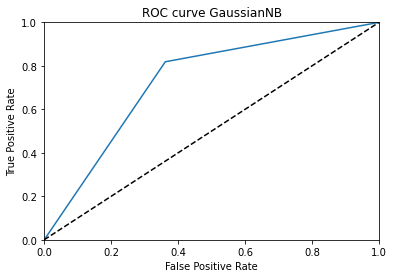

In [27]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve GaussianNB')
plt.show()

fig.savefig('ROC curve GaussianNB')

In [28]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))
print ("MSE", metrics.mean_squared_error(y_test, y_pred))
print ("MAE", metrics.mean_absolute_error(y_test, y_pred))

AUC ROC 0.7285296798414186
MSE 0.5962765957446808
MAE 0.3675531914893617


## MultinomialNB

In [29]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))

beta = 0.5
print ("beta =", beta, 'fbeta_score =', metrics.fbeta_score(y_test, y_pred, beta = 0.5, average='weighted'))

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       1.00      0.12      0.22       253
 Information       0.00      0.00      0.00       169
 Requirement       0.78      1.00      0.88      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.79      1880
   macro avg       0.36      0.22      0.22      1880
weighted avg       0.74      0.79      0.70      1880

beta = 0.5 fbeta_score = 0.6842531158750496


/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
random_search = {'alpha': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'fit_prior': [True, False]}

clf = MultinomialNB()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 24 is smaller than n_iter=80. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.3s finished


RandomizedSearchCV(cv=4, estimator=MultinomialNB(), n_iter=80, n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4, 0.5,
                                                  0.6000000000000001,
                                                  0.7000000000000001, 0.8, 0.9,
                                                  1.0, None],
                                        'fit_prior': [True, False]},
                   random_state=101, verbose=5)

In [31]:
predictionforest = model.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test,predictionforest), '\n')
print(metrics.classification_report(y_test, predictionforest, target_names=le.classes_[np.unique(y_test)]))
acc3 = metrics.accuracy_score(y_test,predictionforest)

[[   0    0    0    5    0]
 [   0   31    1  221    0]
 [   0    0    0  169    0]
 [   0    1    0 1445    0]
 [   0    0    0    7    0]] 

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       0.97      0.12      0.22       253
 Information       0.00      0.00      0.00       169
 Requirement       0.78      1.00      0.88      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.79      1880
   macro avg       0.35      0.22      0.22      1880
weighted avg       0.73      0.79      0.70      1880



/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

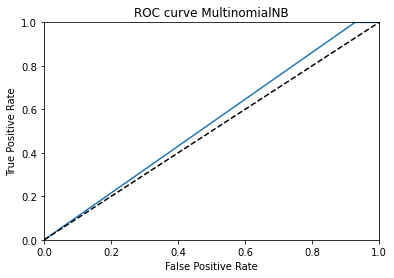

In [33]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve MultinomialNB')
plt.show()

fig.savefig('ROC curve MultinomialNB')

In [34]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))
print ("MSE", metrics.mean_squared_error(y_test, y_pred))
print ("MAE", metrics.mean_absolute_error(y_test, y_pred))

AUC ROC 0.5357142857142857
MSE 0.5898936170212766
MAE 0.3377659574468085


## BernoulliNB

In [35]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))#le.classes_[np.unique(predicted)]

beta = 0.5
print ("beta =", beta, 'fbeta_score =', metrics.fbeta_score(y_test, y_pred, beta = 0.5, average='weighted'))

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       0.76      0.94      0.84       253
 Information       0.51      0.17      0.26       169
 Requirement       0.90      0.94      0.92      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.86      1880
   macro avg       0.43      0.41      0.40      1880
weighted avg       0.84      0.86      0.84      1880

beta = 0.5 fbeta_score = 0.8368288297119147


/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'alpha': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'binarize': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'fit_prior': [True, False]}

clf = BernoulliNB()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.4s finished


RandomizedSearchCV(cv=4, estimator=BernoulliNB(), n_iter=80, n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4, 0.5,
                                                  0.6000000000000001,
                                                  0.7000000000000001, 0.8, 0.9,
                                                  1.0, None],
                                        'binarize': [0.0, 0.1, 0.2,
                                                     0.30000000000000004, 0.4,
                                                     0.5, 0.6000000000000001,
                                                     0.7000000000000001, 0.8,
                                                     0.9, 1.0, None],
                                        'fit_prior': [True, False]},
                   random_state=101, verbose=5)

In [37]:
predictionforest = model.best_estimator_.predict(X_test)
print(metrics.confusion_matrix(y_test,predictionforest), '\n')
print(metrics.classification_report(y_test, predictionforest, target_names=le.classes_[np.unique(y_test)]))
acc3 = metrics.accuracy_score(y_test,predictionforest)

[[   0    2    0    3    0]
 [   0  238    1   14    0]
 [   0    7   29  133    0]
 [   0   61   27 1357    1]
 [   0    6    0    1    0]] 

              precision    recall  f1-score   support

      Figure       0.00      0.00      0.00         5
     Heading       0.76      0.94      0.84       253
 Information       0.51      0.17      0.26       169
 Requirement       0.90      0.94      0.92      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.86      1880
   macro avg       0.43      0.41      0.40      1880
weighted avg       0.84      0.86      0.84      1880



/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

In [39]:
fpr

array([0.        , 0.34792627, 1.        ])

In [40]:
tpr

array([0.       , 0.9384509, 1.       ])

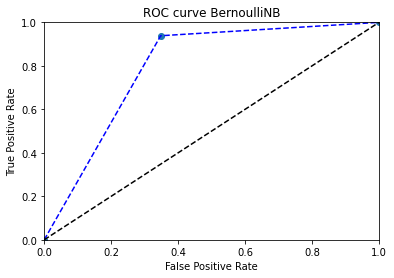

In [41]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr, 'b--')
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve BernoulliNB')
plt.scatter(fpr, tpr)
plt.show()

fig.savefig('ROC curve BernoulliNB')

In [45]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))
print ("MSE", metrics.mean_squared_error(y_test, y_pred))
print ("MAE", metrics.mean_absolute_error(y_test, y_pred))

AUC ROC 0.7952623158753529
MSE 0.29414893617021276
MAE 0.18563829787234043


## XGBClassifier

In [46]:
clf = XGBClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))

/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

      Figure       1.00      1.00      1.00         5
     Heading       0.90      0.87      0.88       253
 Information       0.67      0.44      0.53       169
 Requirement       0.92      0.96      0.94      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.90      1880
   macro avg       0.70      0.65      0.67      1880
weighted avg       0.89      0.90      0.89      1880



In [47]:
# Compute ROC curve and ROC area for each class
#fpr = dict()
#tpr = dict()
roc_auc = dict()

length = len(y_test)

y_test_roc = np.zeros(length)
y_pred_roc = np.zeros(length)

for i in range (length):
    if(y_test[i] == 3): y_test_roc[i] = 1
        
for i in range (length):
    if(y_pred[i] == 3): y_pred_roc[i] = 1
        
fpr, tpr, thresholds = metrics.roc_curve(y_test_roc, y_pred_roc)

In [48]:
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8414663683703973

In [49]:
fpr

array([0.        , 0.28110599, 1.        ])

In [50]:
tpr

array([0.        , 0.96403873, 1.        ])

In [51]:
thresholds

array([2., 1., 0.])

In [52]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

In [53]:
df

,fpr,tpr
0,0.000000,0.000000
1,0.281106,0.964039
2,1.000000,1.000000


In [55]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

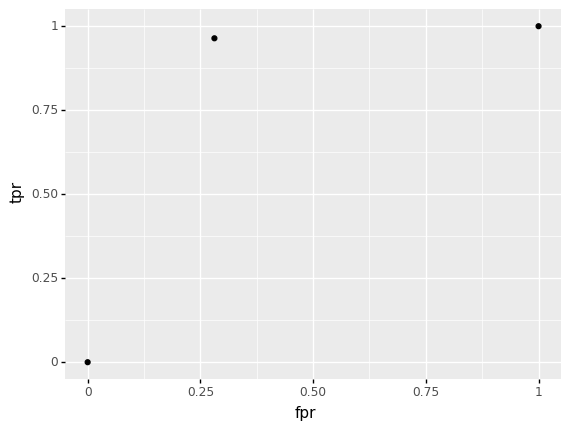

<ggplot: (8765667806190)>

In [56]:
(ggplot(df, aes('fpr','tpr'))
 + geom_point())

In [57]:
y_test_roc

array([1., 1., 1., ..., 0., 1., 1.])

In [58]:
y_pred_roc

array([1., 1., 1., ..., 0., 1., 0.])

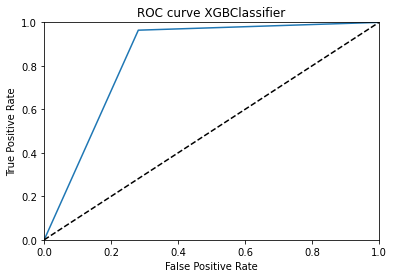

In [59]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve XGBClassifier')
plt.show()

fig.savefig('ROC curve XGBClassifier')

In [60]:
print ("AUC ROC", metrics.roc_auc_score(y_test_roc, y_pred_roc))
print ("MSE", metrics.mean_squared_error(y_test, y_pred))
print ("MAE", metrics.mean_absolute_error(y_test, y_pred))

AUC ROC 0.8414663683703973
MSE 0.21436170212765956
MAE 0.1345744680851064


In [61]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test_roc, y_pred_roc).ravel()
print ("confusion matrix", metrics.confusion_matrix(y_test_roc, y_pred_roc))
print ("tn = ", tn, "fp = ", fp, "fn = ", fn, "tp = ", tp)

confusion matrix [[ 312  122]
 [  52 1394]]
tn =  312 fp =  122 fn =  52 tp =  1394


In [62]:
import scipy.stats as st

random_search = {'alpha': list(np.linspace(0.0, 1.0, 11, dtype = float)) + [None],
               'fit_prior': [True, False],
                'norm': [False, True]}

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

random_search = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}


clf = XGBClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   53.2s finished
/Users/marychikunova/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:44:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8ea8686ee0>,
                                        'n_estima

In [63]:
clf = XGBClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=le.classes_[np.unique(y_test)]))

[15:44:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

      Figure       1.00      1.00      1.00         5
     Heading       0.90      0.87      0.88       253
 Information       0.67      0.44      0.53       169
 Requirement       0.92      0.96      0.94      1446
       Title       0.00      0.00      0.00         7

    accuracy                           0.90      1880
   macro avg       0.70      0.65      0.67      1880
weighted avg       0.89      0.90      0.89      1880



In [64]:
model.best_params_

{'colsample_bytree': 0.9531471559535791,
 'gamma': 1.7919527578742689,
 'learning_rate': 0.15803569462073455,
 'max_depth': 20,
 'min_child_weight': 59.38504505496335,
 'n_estimators': 33,
 'reg_alpha': 29.89561177661934,
 'subsample': 0.9985593337355078}